# Population oscillations
### 1. Overview
In this section we are going to explore different models's ability to reproduce the collective oscillation behavior of *Dictyostelium* cells (Figure 6, below). Another important feature has been shown experimentally is that with $cAMP_{e}$ applied, population oscillations get repressed (Figure 8, below).

With this notebook, you can visualize population mean of $cAMP_{i}$ as well as the that of individual cells in models with noise. Additionally, you can alter parameters of each model, set $cAMP_{e}$ influx concentrations, and see how those affects population-wide oscillations.  
![Figure 6](imgs/pop_oscillation_1.png)
<h5><center>Figure6</center></h5>

![Figure 8](imgs/POP_oscillation_add_cAMP_1.png)
<h6><center>Figure8</center></h6>

#### Let's start by importing packages and setting up time scaling parameters

In [1]:
import os
import numpy as np
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import signal
from scipy.signal import chirp, find_peaks, peak_widths
import pandas as pd
import scipy.io

os.chdir("../compare_models")
from Goldbeter1987_agent_and_pop_FUN import Goldbeter1987_pop_3var
from MaedaLoomis2004_agent_and_pop_FUN import MaedaLoomis2004_pop
from Gregor2010_agent_and_pop_FUN import Gregor2010_pop
from Sgro2015_agent_and_pop_FUN import Sgro2015_pop
from Kamino2017_agent_and_pop_FUN import Kamino2017_pop

from NB_pop_functions import * 
# Normalization parameters
from NormParam import *
os.chdir("../Notebooks") 

### 2. Experimental data 
#### import and plot experimental data

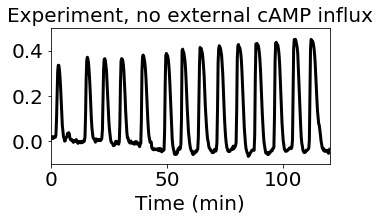

Text(0.7, 0.75, ' High External cAMP, \n 100nM')

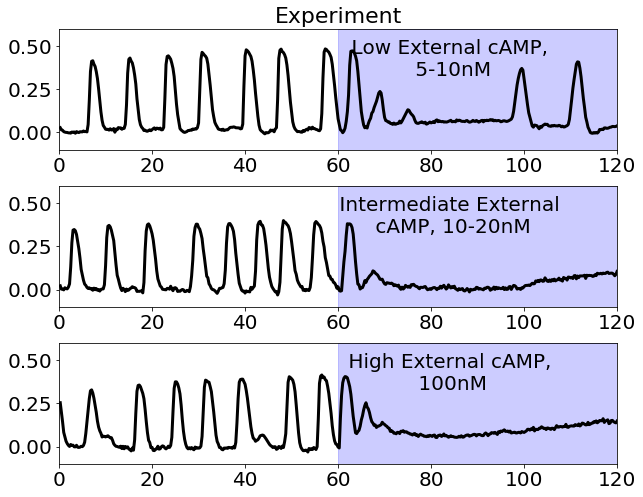

In [2]:
Sgro2015Figure6excel = pd.read_excel(r'../exp_data/Sgro2015DataFormattedforPython.xlsx',sheet_name='Figure6')

fig = plt.figure(figsize=(5, 2.5))
grid = plt.GridSpec(1,1)
ax0= fig.add_subplot(grid[0, 0])
ax0.plot(Sgro2015Figure6excel["Times (min)"],Sgro2015Figure6excel["No External cAMP Mean Trace"],
                              color = 'k',linewidth=3)
ax0.tick_params(axis='both', which='major', labelsize=20)
ax0.set_title('Experiment, no external cAMP influx', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax0.set_ylim([-0.1,0.5]); ax0.set_xlim([0,120])
ax0.set_xlabel('Time (min)', size=20)
plt.show()

fig1 = plt.figure(figsize=(10, 8))
grid = plt.GridSpec(3, 1, wspace=0.5, hspace=0.3)

ax02= fig1.add_subplot(grid[0, 0])
ax02.plot(Sgro2015Figure6excel["Times (min)"],Sgro2015Figure6excel["Low External cAMP Mean Trace"],
                               color = 'k', linewidth=3)
ax02.axvspan(60, 120, alpha=0.2, color='b')
ax02.set_ylim([-0.1,0.6]);ax02.set_xlim([0,120])
ax02.tick_params(grid_linewidth = 15, labelsize = 20)
ax02.text(0.7,0.75,' Low External cAMP, \n 5-10nM', ha='center',va='center',
         transform = ax02.transAxes, color = 'k', fontsize=20)
ax02.set_title('Experiment',size=22)
ax03= fig1.add_subplot(grid[1, 0])
ax03.plot(Sgro2015Figure6excel["Times (min)"],Sgro2015Figure6excel["Intermediate External cAMP Mean Trace"],
                               color = 'k', linewidth=3)
ax03.axvspan(60, 120, alpha=0.2, color='b')
ax03.set_ylim([-0.1,0.6]);ax03.set_xlim([0,120])
ax03.tick_params(grid_linewidth = 15, labelsize = 20)
ax03.text(0.7,0.75,' Intermediate External \n cAMP, 10-20nM', ha='center',va='center',
         transform = ax03.transAxes, color = 'k', fontsize=20)

ax04= fig1.add_subplot(grid[2, 0])
ax04.plot(Sgro2015Figure6excel["Times (min)"],Sgro2015Figure6excel["High External cAMP Mean Trace"],
                               color = 'k', linewidth=3)
ax04.axvspan(60, 120, alpha=0.2, color='b')
ax04.set_ylim([-0.1,0.6]);ax04.set_xlim([0,120])
ax04.tick_params(grid_linewidth = 15, labelsize = 20)
ax04.text(0.7,0.75,' High External cAMP, \n 100nM', ha='center',va='center',
         transform = ax04.transAxes, color = 'k', fontsize=20)

### 3. Matiel 1986
#### Set up parameters (from Table II in [Matiel & Goldbeter 1986](https://www.sciencedirect.com/science/article/pii/S0006349587832757?via%3Dihub) )

In [3]:
k1 = 0.036     # per min
k2 = 0.666    # per min
L1 = 10; L2 = 0.005 
c = 10;           # 0.15 ~ 50
lamda = 0.01; theta = 0.01; e =  1 ; q = 4000; sig= 0.6
v = 12; k = 4 # k prime in the paper
ki = 1.7; kt = 0.9; kc = 5.4; h = 5
Goldbeter3PopParam={'k1':k1,'k2':k2,'L1':L1,'L2':L2, 'c':c, 'lamda':lamda,\
            'theta':theta, 'e':e, 'q':q,'sig':sig, 'v':v, 'k':k, \
            'ki':ki,'kt':kt, 'kc':kc,'h':h}
dt=0.001; t_tot=30; t=list(np.arange(0,t_tot*Nt_Goldbeter,dt))

#### Define $cAMP_{e}$ influx trace and get $cAMP_i$ simulation response

In [4]:
# cAMPe influx level. By default low, itermediate and high levels are 0.01, 0.02 and 0.1
cAMPext_influx=0.01 

stim_time= 0.5 # cAMPext_influx happens at half the total time
stim_time_step=int(round(stim_time*t_tot*Nt_Goldbeter/dt)) # at this time step input is applied
campExt_influx_trace=np.zeros(len(t))
campExt_influx_trace[stim_time_step:] = cAMPext_influx

[t_plot_Goldbeter, b_trace, p_trace, g_trace] = Goldbeter_pop(Goldbeter3PopParam,dt,t,campExt_influx_trace)
# Rescale time
t_plot_Goldbeter = t_plot_Goldbeter/(Nt_Goldbeter)
# Normalize height 
b_trace_norm = b_trace/Nh_Goldbeter

#### Plot population $cAMP_i$  trace

In [5]:
# Plot outputs
plot_POP_oscillation(t_plot_Goldbeter,b_trace_norm, cAMPext_influx, t_tot, stim_time)

TypeError: plot_POP_oscillation() missing 1 required positional argument: 'title'

### 4. Maeda 2004
#### Set up parameters (from supplementary in [Maeda et al 2004](https://science.sciencemag.org/content/304/5672/875/tab-figures-data) )

In [ ]:
k1=2.0; k2=0.9; k3=2.5; k4=1.5; k5=0.6
k6=0.8; k7=1.0; k8=1.3; k9=0.3; k10=0.8
k11=0.7; k12=4.9; k13=23; k14=4.5
MaedaPopParam={'k1':k1,'k2':k2,'k3':k3,'k4':k4,'k5':k5,'k6':k6,\
            'k7':k7,'k8':k8,'k9':k9,'k10':k10,'k11':k11,'k12':k12,\
            'k13':k13,'k14':k14}
dt=0.001; t_tot=60; t=list(np.arange(0,t_tot*Nt_Maeda,dt))

#### Define $cAMP_{e}$ influx trace and get $cAMP_i$ simulation response

In [ ]:
# cAMPe influx level. By default low, itermediate and high levels are 0.005, 0.05 and 0.5
cAMPext_influx=0.05 

stim_time= 0.75 # cAMPext_influx happens at 3/4 of total time
# allow for oscillation stablize for longer before cAMPe is applied
stim_time_step=int(round(stim_time*t_tot*Nt_Maeda/dt)) # at this time step input is applied
cAMPext_influx_trace=np.zeros(len(t))
cAMPext_influx_trace[stim_time_step:] = cAMPext_influx

[t_plot_Maeda, cAMPi_trace, ERK2_trace,cAMPe_trace] = Maeda_pop(MaedaPopParam,dt,t,cAMPext_influx_trace)
# Rescale time
t_plot_Maeda = t_plot_Maeda/(Nt_Maeda)
# Normalize height 
cAMPi_trace_norm = cAMPi_trace/Nh_Maeda

#### Plot population $cAMP_i$  trace

In [ ]:
# Plot outputs
plot_POP_oscillation(t_plot_Maeda[int(0.5*len(t)):],cAMPi_trace_norm[int(0.5*len(t)):], cAMPext_influx, t_tot, stim_time)

### 5. Gregor 2010 
#### Set up parameters

In [ ]:
Amax=20;  Abas=0.4 # uM
w=2*math.pi/6 # min-1
Vc=1.1e-9 # ml
St=1.33 # cm2
Sc=1.3e-6 # cm2
K=0.0004 # uM, 400 pM
c_sec= 3.6 # min-1
c_excite=1.01 # min-1
Nc=100 # Num of cells
rho = 1/12 #1/ml
Vt = 1 #chamber size ml
k = 5 #ml/min
eta = 0.002 # noise strength
GregorPopParam={'Amax':Amax,'Abas':Abas,'w':w,'Vc':Vc,'St':St,'Sc':Sc,'K':K,\
                'c_sec':c_sec,'c_excite':c_excite,'eta':eta, \
                'Nc':Nc, 'rho':rho, 'Vt':Vt,'k':k}
dt=0.001; t_tot=30; t=list(np.arange(0,t_tot*Nt_Gregor,dt))

#### Define $cAMP_{e}$ influx trace and get $cAMP_i$ simulation response

In [ ]:
# cAMPe influx level. By default low, itermediate and high levels are 0.0001, 10 and 1000
cAMPext_influx=10

stim_time= 0.5 # cAMPext_influx happens at half the total time
# allow for oscillation stablize for longer before cAMPe is applied
stim_time_step=int(round(stim_time*t_tot*Nt_Gregor/dt)) # at this time step input is applied
cAMPext_influx_trace=np.zeros(len(t))
cAMPext_influx_trace[stim_time_step:] = cAMPext_influx
time_separation = 0

[t_plot_Gregor,  gregor_campCyto_trace, gregor_thetai_trace, gregor_campExt_trace] = Gregor_pop(GregorPopParam,
                                                                                                dt,t, cAMPext_influx_trace, time_separation)
# Rescale time
t_plot_Gregor = t_plot_Gregor/(Nt_Gregor)

# Take cAMPi population mean and normalize height
gregor_campCyto_trace_norm = gregor_campCyto_trace/Nh_Gregor
gregor_campCyto_trace_mean= np.mean(gregor_campCyto_trace,axis = 0)
gregor_campCyto_trace_mean_norm = gregor_campCyto_trace_mean/Nh_Gregor

#### Plot population $cAMP_i$  trace

In [ ]:
# specify which single cell traces to display
SC_traces_idx = [0,1,2,3,4,5]
# plot population mean and individual traces
plot_POP_oscillation(t_plot_Gregor,gregor_campCyto_trace_mean_norm, cAMPext_influx, t_tot, stim_time,gregor_campCyto_trace_norm, SC_traces_idx)

### 6. Sgro 2015 
#### Set up parameters

In [ ]:
e=0.1 # excitability
sigma = 0.15 # noise strength
tauA=0.09; tauR=tauA/e; g=0.5
N = 100; rho = 10**(-3.5); j = 0.5
SgroPopParam={'e':e,'tauA':tauA,'tauR':tauR,'g':g,'c0':1.2,'sigma':sigma,'N':N,\
            'a':0.058,'alpha0':800,'alpha_pde':1000,'Kd':1e-5,'S':1e6,\
            'offset_A':1.5,'flux_thrs':0, 'rho': rho,'j': j}

dt=0.001 ; t_tot=30; t=list(np.arange(0,t_tot*Nt_Sgro,dt))

#### Define $cAMP_{e}$ influx trace and get $cAMP_i$ simulation response

In [ ]:
# cAMPe influx level. By default low, itermediate and high levels are 10, 20 and 100
cAMPext_influx = 10 

stim_time= 0.5 # cAMPext_influx happens at half the total time
# allow for oscillation stablize for longer before cAMPe is applied
stim_time_step=int(round(stim_time*t_tot*Nt_Sgro/dt)) # at this time step input is applied
cAMPext_influx_trace=np.zeros(len(t))
cAMPext_influx_trace[stim_time_step:] = cAMPext_influx
time_separation = 0

[t_plot_Sgro, A_trace_plot,  R_trace_orig, R_trace_plot, cAMPext_trace] = Sgro_pop(SgroPopParam,dt,t,cAMPext_influx_trace, time_separation)
# Rescale time
t_plot_Sgro = t_plot_Sgro/(Nt_Sgro)
# Take cAMPi (A) population mean and normalize height
A_trace_plot_norm = A_trace_plot/Nh_Sgro
A_trace_mean= np.mean(A_trace_plot,axis = 0)
A_trace_mean_norm = A_trace_mean/Nh_Sgro

#### Plot population $cAMP_i$  trace

In [ ]:
# specify which single cell traces to display
SC_traces_idx = [0,1,2,3,4,5]
# plot population mean and individual traces
plot_POP_oscillation(t_plot_Sgro,A_trace_mean_norm, cAMPext_influx, t_tot, stim_time,A_trace_plot_norm, SC_traces_idx)

### 7. Kamino 2017
#### Set up parameters

In [ ]:
tau=1.5; n=2; K=4; kt=2; delta=0
gamma=3 # cAMPe dilution/degradation rate 
rho= 1 # population density
KaminoPopParam={'tau':tau,'n':n,'K':K,'kt':kt,'delta':delta,\
               'gamma':gamma,'rho':rho}
dt=0.001; t_tot = 30; t=list(np.arange(0,t_tot*Nt_Kamino,dt))

#### Define $cAMP_{e}$ influx trace and get $cAMP_i$ simulation response

In [ ]:
# cAMPe influx level. By default low, itermediate and high levels are 0.001,0.002 and 0.1
cAMPext_influx=0.001

stim_time= 0.5 # cAMPext_influx happens at half the total time
stim_time_step=int(round(stim_time*t_tot*Nt_Kamino/dt)) # at this time step input is applied
cAMPext_influx_trace=np.zeros(len(t))
cAMPext_influx_trace[stim_time_step:] = cAMPext_influx

[t_plot_Kamino, y_trace, x_trace, z_trace] = Kamino_pop(KaminoPopParam,dt,t,cAMPext_influx_trace)
# Rescale time
t_plot_Kamino = t_plot_Kamino/(Nt_Kamino)
# Normalize height 
y_trace_norm = y_trace/Nh_Kamino

#### Plot population $cAMP_i$  trace

In [ ]:
# Plot outputs
plot_POP_oscillation(t_plot_Kamino,y_trace_norm, cAMPext_influx, t_tot, stim_time)